In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install geopandas shapely mapclassify
import geopandas as gpd
from shapely.geometry import Polygon
import mapclassify
import os
pd.set_option("display.max_columns", 99)
# os.chdir("/home/joosungm/projects/def-lelliott/joosungm/projects/ssc23-case-comp/")

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/projects/ssc23-case-comp")

In [ ]:
# Load data
geo_df = pd.read_csv("./data/user_data/01_iv_analysis/C01_geo_df.csv")
# - replace " " with "_" in provincename column in geo_df
geo_df["provincename"] = geo_df["provincename"].str.replace(" ", "_")

prod_temp = pd.read_csv("./data/user_data/01_iv_analysis/C01_prod_temp.csv")
iv_all = pd.read_csv("./data/user_data/02_iv_extreme/iv_extreme_result.csv")
iv_all["provincename"] = iv_all["provincename"].str.replace(" ", "_")

print(geo_df.shape)
# print(geo_df.columns)

print(prod_temp.shape)
# print(prod_temp.columns)

print(iv_all.shape)
# print(iv_all.columns)

# - Load province and CSD boundaries (from Statistics Canada)
prov_shapefile = './data/user_data/_other/lpr_000b21a_e.shp'
province = gpd.read_file(prov_shapefile)
province = province.iloc[0:10, :]

csd_shapefile = './data/user_data/_other/lcsd000b21a_e.shp'
csd = gpd.read_file(csd_shapefile)

(5054, 4)
(1516200, 32)
(280, 9)


In [ ]:
treatments = ["tmax_flag", "tmin_flag"]
treatment = treatments[0]

prod_temp_sub = prod_temp.loc[prod_temp.month == 12, 
    ["GeoUID", "Dominant_NAICS"]].drop_duplicates().sort_values(
        by = "GeoUID").reset_index(drop = True)

merged_data = geo_df.merge(
    right = prod_temp_sub, 
    on = "GeoUID", how = "left").drop_duplicates().reset_index(
        drop = True).merge(
            right = iv_all.loc[iv_all.treatment == treatment], 
            left_on = ["provincename", "Dominant_NAICS"], 
            right_on = ["provincename", "industry"], 
            how = "left").sort_values(
                by = "GeoUID").drop(
                    columns = ["industry"])

# - If GeoUID is repeated, then choose the one with is_sig == True and the largest pval(param)
merged_data = merged_data.sort_values(
    by = ["GeoUID", "is_sig", "pval(param)"], 
    ascending = [True, False, True]).drop_duplicates(
        subset = "GeoUID", keep = "first").reset_index(drop = True)

# - Change the data type of GeoUID to str
merged_data["GeoUID"] = merged_data["GeoUID"].astype(str)

merged_data = merged_data.dropna(subset = "Dominant_NAICS").reset_index(drop = True)

print(merged_data.shape)
merged_data.sample(5)

(4476, 12)


,GeoUID,Region.Name,provincename,geometry,Dominant_NAICS,param,pval(param),pval(overid),pval(endog),treatment,is_sig,new_param
158,1004022,"Division No. 4, Subd. E (SNO)",Newfoundland_and_Labrador,"MULTIPOLYGON (((-58.8241 48.5732, -58.8246 48....",X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.443,0.168,0.000,0.000,tmax_flag,False,0.000
190,1006009,Gander (T),Newfoundland_and_Labrador,"MULTIPOLYGON (((-54.7125 48.9685, -54.646 48.9...",X52.Finance.and.insurance.53.Real.estate.and.r...,-1.018,0.153,0.099,0.023,tmax_flag,False,0.000
2921,4705093,Churchbridge No. 211 (RM),Saskatchewan,"MULTIPOLYGON (((-101.539 51.1251, -101.5396 51...",X11.Agriculture.forestry.fishing.hunting.21.Mi...,-1.572,0.001,0.001,0.000,tmax_flag,True,-1.572
1433,2452095,Mandeville (MÉ),Quebec,"MULTIPOLYGON (((-73.3322 46.3395, -73.3347 46....",X31.33.Manufacturing,1.892,0.000,0.326,0.000,tmax_flag,False,0.000
4146,5921036,Nanaimo H (RDA),British_Columbia,"MULTIPOLYGON (((-124.7567 49.4557, -124.7545 4...",X52.Finance.and.insurance.53.Real.estate.and.r...,1.313,0.001,0.611,0.000,tmax_flag,False,0.000


In [ ]:
print(np.max(merged_data["new_param"]))
print(np.min(merged_data["new_param"]))

0.478
-2.099


In [ ]:
country_data = merged_data.copy()

# - Add boundary data for the census subdivisions.
country_data = country_data.drop(columns = "geometry").merge(
    right = csd[["CSDUID", "geometry"]], 
    left_on = "GeoUID", right_on = "CSDUID", how = "left").drop(
        columns = "CSDUID").reset_index(
        drop = True)

# - Make GeoDataFrame.
country_data = gpd.GeoDataFrame(country_data, 
                                geometry = "geometry", crs = "EPSG:3347")

# - Assign categories by param(\beta_{tavg}: 
#   the effect of a unit increase in tavg on log(production)).

country_data["group"] = np.select([country_data["new_param"] < -0.3,
                                   (-0.3 <= country_data["new_param"]) & (country_data["new_param"] < -0.15 ),
                                   (-0.15 <= country_data["new_param"]) & (country_data["new_param"] < 0),
                                   (country_data["new_param"] == 0),
                                   (0 < country_data["new_param"]) & (country_data["new_param"] <= 0.15),
                                   (0.15 < country_data["new_param"]) & (country_data["new_param"] <= 0.3),
                                   (0.3 < country_data["new_param"])
                                   ], [0, 1, 2, 3, 4, 5, 6])


country_data.sample(5)

,GeoUID,Region.Name,provincename,Dominant_NAICS,param,pval(param),pval(overid),pval(endog),treatment,is_sig,new_param,geometry,group
1109,2429050,Saint-René (PE),Quebec,X31.33.Manufacturing,1.892,0.000,0.326,0.0,tmax_flag,False,0.000,"POLYGON ((7835650.817 1376233.931, 7836406.749...",3
3261,4713009,Flaxcombe (VL),Saskatchewan,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-1.572,0.001,0.001,0.0,tmax_flag,True,-1.572,"POLYGON ((4995263.294 1872939.171, 4995016.929...",0
1683,2478055,Montcalm (MÉ),Quebec,X23.Construction,1.017,0.000,0.094,0.0,tmax_flag,False,0.000,"POLYGON ((7551538.320 1282126.077, 7551629.900...",3
2187,3539002,Newbury (VL),Ontario,X31.33.Manufacturing,2.171,0.000,0.027,0.0,tmax_flag,False,0.000,"POLYGON ((7046095.946 783431.394, 7046062.354 ...",3
2922,4705094,Churchbridge (T),Saskatchewan,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-1.572,0.001,0.001,0.0,tmax_flag,True,-1.572,"POLYGON ((5503129.340 1693791.506, 5503035.969...",0


In [ ]:
# most negatively affected
display(merged_data[["Region.Name", "provincename", "Dominant_NAICS", "new_param"]].sort_values(
    by = "new_param").head(5))

# most positively affected
display(merged_data[["Region.Name", "provincename", "Dominant_NAICS", "new_param"]].sort_values(
    by = "new_param").tail(5))

,Region.Name,provincename,Dominant_NAICS,new_param
3364,Waldheim (T),Saskatchewan,X52.Finance.and.insurance.53.Real.estate.and.r...,-2.099
3527,Montreal Lake 106 (IRI),Saskatchewan,X52.Finance.and.insurance.53.Real.estate.and.r...,-2.099
2985,Saskatchewan Beach (RV),Saskatchewan,X52.Finance.and.insurance.53.Real.estate.and.r...,-2.099
2962,Fort San (RV),Saskatchewan,X52.Finance.and.insurance.53.Real.estate.and.r...,-2.099
2948,Regina (CY),Saskatchewan,X52.Finance.and.insurance.53.Real.estate.and.r...,-2.099


,Region.Name,provincename,Dominant_NAICS,new_param
1881,Passes-Dangereuses (NO),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.478
1880,Saint-Stanislas (MÉ),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.478
1879,Saint-Eugène-d'Argentenay (MÉ),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.478
1877,Girardville (MÉ),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.478
1961,Eeyou Istchee Baie-James (MÉ),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.478


In [ ]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
            
group_dict = dict(map(lambda key,value : (key, value), [0,1,2,3,4,5,6], [" < -0.3)", "[-0.3, -0.15)", "[-0.15, 0)", "[0]", "(0, 0.15]", "(0.15, 0.3]", "(0.3 < "]))
print(group_dict)

{0: ' < -0.3)', 1: '[-0.3, -0.15)', 2: '[-0.15, 0)', 3: '0', 4: '(0, 0.15]', 5: '(0.15, 0.3]', 6: '(0.3 < '}


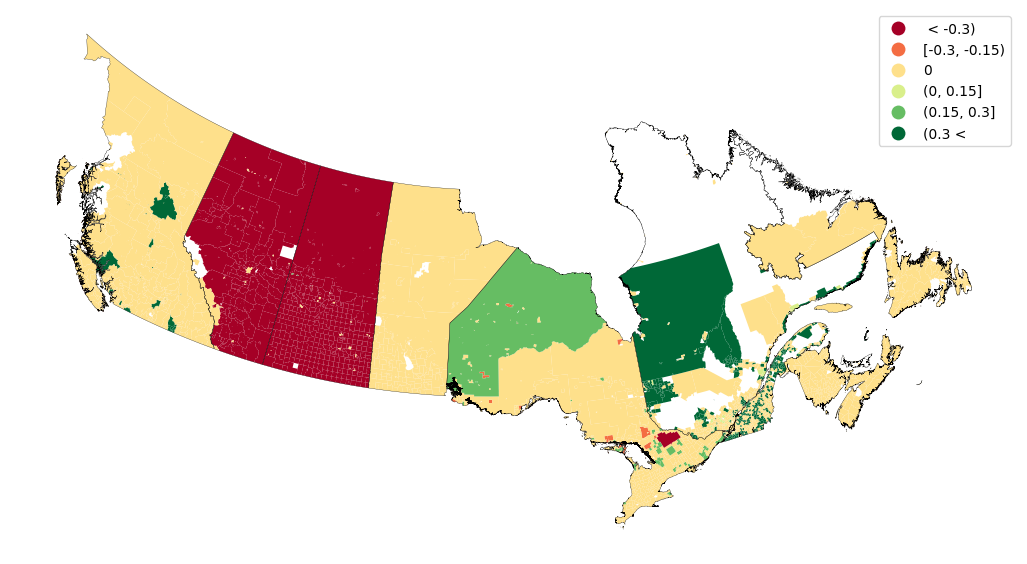

In [ ]:
fig = plt.figure(figsize = (13, 13))
ax = plt.gca()

ax.set_aspect("equal")
province.plot(
    ax = ax,
    edgecolor = "black", 
    facecolor = "none",
    # color = "lightgrey",
    linewidth = 0.2,
    zorder = 2)

country_data.plot(
    column = "group",
    categorical = True,
    ax = ax, 
    cmap = "RdYlGn", alpha = 1, linewidth = 1,
    zorder = 1,
    legend = True,
    missing_kwds={
        "color": "lightgrey",
        "label": "NA",
    }
    )

replace_legend_items(ax.get_legend(), group_dict)

# ax.set_title("TBD")
ax.axis("off")
plt.show()

In [ ]:
fig.savefig("./figs/iv_extreme_result_tmax.png", dpi = 300, transparent = False)
fig.savefig("./figs/iv_extreme_result_tmax2.png", dpi = 300, transparent = True)

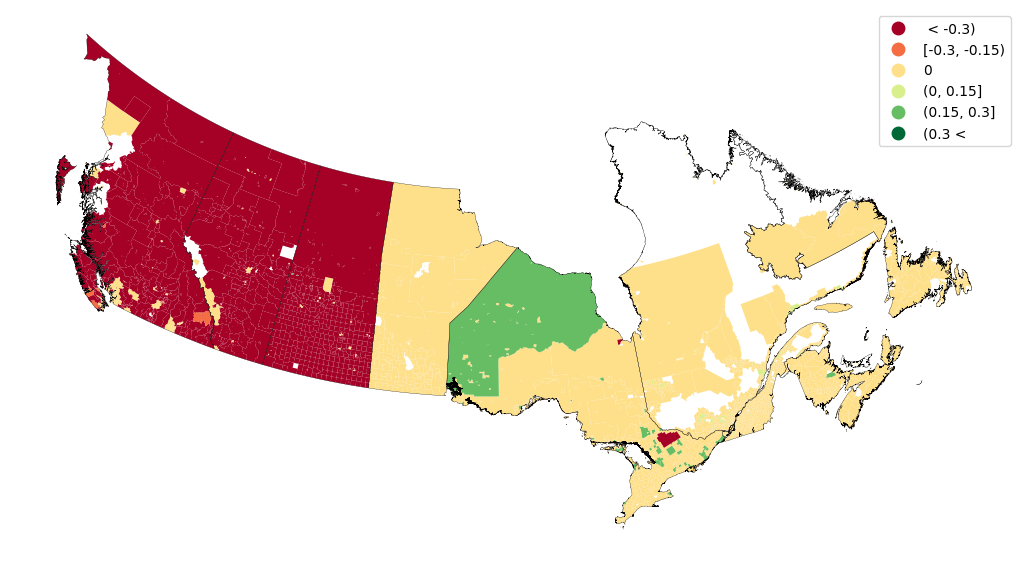

In [ ]:
# Repeat the process for treatment = tmin_flag

treatments = ["tmax_flag", "tmin_flag"]
treatment = treatments[1]

prod_temp_sub = prod_temp.loc[prod_temp.month == 12, 
    ["GeoUID", "Dominant_NAICS"]].drop_duplicates().sort_values(
        by = "GeoUID").reset_index(drop = True)

merged_data = geo_df.merge(
    right = prod_temp_sub, 
    on = "GeoUID", how = "left").drop_duplicates().reset_index(
        drop = True).merge(
            right = iv_all.loc[iv_all.treatment == treatment], 
            left_on = ["provincename", "Dominant_NAICS"], 
            right_on = ["provincename", "industry"], 
            how = "left").sort_values(
                by = "GeoUID").drop(
                    columns = ["industry"])

# - If GeoUID is repeated, then choose the one with is_sig == True and the largest pval(param)
merged_data = merged_data.sort_values(
    by = ["GeoUID", "is_sig", "pval(param)"], 
    ascending = [True, False, True]).drop_duplicates(
        subset = "GeoUID", keep = "first").reset_index(drop = True)

# - Change the data type of GeoUID to str
merged_data["GeoUID"] = merged_data["GeoUID"].astype(str)

merged_data = merged_data.dropna(subset = "Dominant_NAICS").reset_index(drop = True)

# print(merged_data.shape)
# merged_data.sample(5)

country_data = merged_data.copy()

# - Add boundary data for the census subdivisions.
country_data = country_data.drop(columns = "geometry").merge(
    right = csd[["CSDUID", "geometry"]], 
    left_on = "GeoUID", right_on = "CSDUID", how = "left").drop(
        columns = "CSDUID").reset_index(
        drop = True)

# - Make GeoDataFrame.
country_data = gpd.GeoDataFrame(country_data, 
                                geometry = "geometry", crs = "EPSG:3347")

# - Assign categories by param(\beta_{tavg}: 
#   the effect of a unit increase in tavg on log(production)).

country_data["group"] = np.select([country_data["new_param"] < -0.3,
                                   (-0.3 <= country_data["new_param"]) & (country_data["new_param"] < -0.15 ),
                                   (-0.15 <= country_data["new_param"]) & (country_data["new_param"] < 0),
                                   (country_data["new_param"] == 0),
                                   (0 < country_data["new_param"]) & (country_data["new_param"] <= 0.15),
                                   (0.15 < country_data["new_param"]) & (country_data["new_param"] <= 0.3),
                                   (0.3 < country_data["new_param"])
                                   ], [0, 1, 2, 3, 4, 5, 6])

# fig, ax = plt.subplots(1, 1, figsize = (13, 13))
fig = plt.figure(figsize = (13, 13))
ax = plt.gca()

ax.set_aspect("equal")
province.plot(
    ax = ax,
    edgecolor = "black", 
    facecolor = "none",
    # color = "lightgrey",
    linewidth = 0.2,
    zorder = 2)

country_data.plot(
    column = "group",
    categorical = True,
    ax = ax, 
    cmap = "RdYlGn", alpha = 1, linewidth = 1,
    zorder = 1,
    legend = True,
    missing_kwds={
        "color": "lightgrey",
        "label": "NA",
    }
    )

replace_legend_items(ax.get_legend(), group_dict)

# ax.set_title("TBD")
ax.axis("off")
plt.show()

fig.savefig("./figs/iv_extreme_result_tmin.png", dpi = 300, transparent = False)
fig.savefig("./figs/iv_extreme_result_tmin2.png", dpi = 300, transparent = True)

In [ ]:
iv_all = pd.read_csv("./data/user_data/02_iv_extreme/iv_extreme_result.csv")
iv_all["provincename"] = iv_all["provincename"].str.replace(" ", "_")
prov_names = iv_all.provincename.unique()
print(prov_names)
industry_names = iv_all.industry.unique()
print(industry_names)

['British_Columbia' 'Alberta' 'Ontario' 'Quebec'
 'Newfoundland_and_Labrador' 'New_Brunswick' 'Saskatchewan' 'Manitoba'
 'Nova_Scotia' 'Prince_Edward_Island']
['X22.Utilities' 'X23.Construction' 'X31.33.Manufacturing'
 'X48.49.Transportation.and.warehousing' 'X61.Educational.services'
 'X62.Health.care.and.social.assistance'
 'X72.Accommodation.and.food.services'
 'X81.Other.services..except.public.administration.'
 'X91.Public.administration'
 'X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction'
 'X41.Wholesale.trade.44.45.Retail.trade'
 'X52.Finance.and.insurance.53.Real.estate.and.rental.and.leasing'
 'X54.Professional..scientific.and.technical.services.55.56'
 'X51.Information.culture.and.recreation.71']


In [ ]:
iv_new = pd.DataFrame({"industry":industry_names})
treatment = "tmax_flag"
# prov_names = ["British_Columbia"]

for prov_name in prov_names:

    iv_sub = iv_all.loc[(iv_all["provincename"] == prov_name) & (iv_all["treatment"] == treatment), ]

    iv_sub[prov_name] = np.where(iv_sub["is_sig"] == True, iv_sub["new_param"], 0)
    iv_new = pd.merge(iv_new, iv_sub.loc[:, ["industry", prov_name]], on = "industry", how = "left")

iv_table = iv_new[["industry", "British_Columbia", "Alberta", "Saskatchewan", "Manitoba", "Ontario", "Quebec", "New_Brunswick", "Nova_Scotia", "Prince_Edward_Island", "Newfoundland_and_Labrador"]]

iv_table.to_csv("./data/user_data/02_iv_extreme/B03_iv_extreme_tmax.csv", index = False)

In [ ]:
display(iv_table)

,industry,British_Columbia,Alberta,Saskatchewan,Manitoba,Ontario,Quebec,New_Brunswick,Nova_Scotia,Prince_Edward_Island,Newfoundland_and_Labrador
0,X22.Utilities,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
1,X23.Construction,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,X31.33.Manufacturing,0.376,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
3,X48.49.Transportation.and.warehousing,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,X61.Educational.services,0.000,0.000,0.262,0.0,-0.326,0.000,0.0,0.0,0.0,0.0
5,X62.Health.care.and.social.assistance,0.000,0.000,0.000,0.0,-0.220,0.000,0.0,0.0,0.0,0.0
6,X72.Accommodation.and.food.services,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
7,X81.Other.services..except.public.administration.,0.000,0.000,-0.996,0.0,0.334,0.000,0.0,0.0,0.0,0.0
8,X91.Public.administration,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
9,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.000,-1.068,-1.572,0.0,0.000,0.478,0.0,0.0,0.0,0.0


In [ ]:
iv_new = pd.DataFrame({"industry":industry_names})
treatment = "tmin_flag"
# prov_names = ["British_Columbia"]

for prov_name in prov_names:

    iv_sub = iv_all.loc[(iv_all["provincename"] == prov_name) & (iv_all["treatment"] == treatment), ]

    iv_sub[prov_name] = np.where(iv_sub["is_sig"] == True, iv_sub["new_param"], 0)
    iv_new = pd.merge(iv_new, iv_sub.loc[:, ["industry", prov_name]], on = "industry", how = "left")

iv_table = iv_new[["industry", "British_Columbia", "Alberta", "Saskatchewan", "Manitoba", "Ontario", "Quebec", "New_Brunswick", "Nova_Scotia", "Prince_Edward_Island", "Newfoundland_and_Labrador"]]

iv_table.to_csv("./data/user_data/02_iv_extreme/B03_iv_extreme_tmin.csv", index = False)

In [ ]:
display(iv_table)

,industry,British_Columbia,Alberta,Saskatchewan,Manitoba,Ontario,Quebec,New_Brunswick,Nova_Scotia,Prince_Edward_Island,Newfoundland_and_Labrador
0,X22.Utilities,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
1,X23.Construction,-0.152,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
2,X31.33.Manufacturing,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
3,X48.49.Transportation.and.warehousing,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
4,X61.Educational.services,-0.266,0.000,0.286,0.0,-0.437,0.000,0.000,0.0,0.0,0.0
5,X62.Health.care.and.social.assistance,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
6,X72.Accommodation.and.food.services,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
7,X81.Other.services..except.public.administration.,0.329,0.000,-1.050,0.0,0.000,0.000,0.000,0.0,0.0,0.0
8,X91.Public.administration,-0.568,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0
9,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-0.876,-0.649,-1.651,0.0,0.000,0.000,0.000,0.0,0.0,0.0
